# Devoir 3 - Problème 1: Test de modèles linéaires d'évaluation d'actifs

## Partie (a): Importation et exploration des données

Cette section importe les données de Ken French (5 facteurs + momentum + 17 portefeuilles sectoriels) pour la période 1980-2021.

### 1. Importation des modules nécessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Modules importés avec succès!")

Modules importés avec succès!


### 2. Téléchargement des données de Ken French

Nous allons télécharger:
- Les 5 facteurs de Fama-French (F-F_Research_Data_5_Factors_2x3)
- Le facteur Momentum (F-F_Momentum_Factor)
- Les 17 portefeuilles sectoriels (17_Industry_Portfolios)

In [22]:
import pandas_datareader as pdr
from pandas_datareader.famafrench import get_available_datasets

# Fonction pour télécharger et nettoyer les données de Ken French
def download_french_data(dataset_name, start_date, end_date):
    """
    Télécharge les données de Ken French et retourne un DataFrame nettoyé
    """
    data = pdr.DataReader(dataset_name, 'famafrench', start=start_date, end=end_date)
    # Les données sont retournées comme un dictionnaire de DataFrames
    # On prend généralement le premier élément (données mensuelles)
    df = data[0]
    return df

# Période d'échantillonnage
start_date = '1980-01-01'
end_date = '2021-12-31'

print("Téléchargement des données...")

Téléchargement des données...


In [23]:
# Téléchargement des 5 facteurs de Fama-French
ff5_data = download_french_data('F-F_Research_Data_5_Factors_2x3', start_date, end_date)
print("✓ 5 facteurs Fama-French téléchargés")
print(f"  Shape: {ff5_data.shape}")
print(f"  Colonnes: {list(ff5_data.columns)}")

# Téléchargement du facteur Momentum
mom_data = download_french_data('F-F_Momentum_Factor', start_date, end_date)
print("\n✓ Facteur Momentum téléchargé")
print(f"  Shape: {mom_data.shape}")
print(f"  Colonnes: {list(mom_data.columns)}")

# Téléchargement des 17 portefeuilles sectoriels
ind17_data = download_french_data('17_Industry_Portfolios', start_date, end_date)
print("\n✓ 17 portefeuilles sectoriels téléchargés")
print(f"  Shape: {ind17_data.shape}")
print(f"  Colonnes: {list(ind17_data.columns)}")

# Lexique des abréviations d'industries (Ken French 17)
lexique_industries = pd.DataFrame({
    'Abréviation': ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other'],
    'Nom complet': [
        'Food Products', 'Mining and Minerals', 'Oil and Petroleum Products', 'Apparel', 'Consumer Durables', 'Chemicals', 'Consumer Goods', 'Construction and Construction Materials', 'Steel Works', 'Fabricated Products and Machinery', 'Machinery and Business Equipment', 'Automobiles and Trucks', 'Transportation', 'Utilities', 'Retail Stores', 'Financial', 'Other'
    ]
})
print("\n" + "="*80)
print("Lexique des 17 portefeuilles sectoriels (Ken French):")
print("="*80)
print(lexique_industries.to_string(index=False))

✓ 5 facteurs Fama-French téléchargés
  Shape: (504, 6)
  Colonnes: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

✓ Facteur Momentum téléchargé
  Shape: (504, 1)
  Colonnes: ['Mom']

✓ Facteur Momentum téléchargé
  Shape: (504, 1)
  Colonnes: ['Mom']

✓ 17 portefeuilles sectoriels téléchargés
  Shape: (504, 17)
  Colonnes: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']

Lexique des 17 portefeuilles sectoriels (Ken French):
Abréviation                             Nom complet
       Food                           Food Products
      Mines                     Mining and Minerals
        Oil              Oil and Petroleum Products
      Clths                                 Apparel
      Durbl                       Consumer Durables
      Chems                               Chemicals
      Cnsum                          Consumer Goods
      Cnstr Construction and Construction Materials
   

### 2.5. Conversion des rendements bruts en excédentaires

Selon la documentation Ken French, les portefeuilles sectoriels sont en rendements **bruts** (value-weighted). On soustrait donc le taux sans risque (RF) pour obtenir les rendements excédentaires nécessaires à l'analyse des modèles de facteurs.

### 3. Fusion et alignement des données

Nous allons créer un dataset unifié avec les 6 facteurs (5 FF + Momentum) et les 17 portefeuilles sectoriels.

In [24]:
# Créer le dataset des 6 facteurs en fusionnant FF5 et Momentum
# On garde seulement les 5 facteurs (sans RF pour l'instant)
factors_5 = ff5_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].copy()

# Extraire le momentum (UMD)
momentum = mom_data[['Mom   ']].copy() if 'Mom   ' in mom_data.columns else mom_data.iloc[:, 0].to_frame()
momentum.columns = ['UMD']

# Fusionner pour obtenir les 6 facteurs
factors_6 = pd.concat([factors_5, momentum], axis=1)
factors_6 = factors_6.dropna()

print("Dataset des 6 facteurs créé:")
print(f"  Shape: {factors_6.shape}")
print(f"  Période: {factors_6.index[0]} à {factors_6.index[-1]}")
print(f"  Facteurs: {list(factors_6.columns)}")

# Les portefeuilles sectoriels
industries = ind17_data.copy()
industries = industries.dropna()

print("\nDataset des 17 industries:")
print(f"  Shape: {industries.shape}")
print(f"  Période: {industries.index[0]} à {industries.index[-1]}")
print(f"  Industries: {list(industries.columns)}")

Dataset des 6 facteurs créé:
  Shape: (504, 6)
  Période: 1980-01 à 2021-12
  Facteurs: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

Dataset des 17 industries:
  Shape: (504, 17)
  Période: 1980-01 à 2021-12
  Industries: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


In [25]:
# CORRECTION: Convertir les industries en rendements excédentaires
# Les données de Ken French pour les industries sont en rendements BRUTS
# Nous devons soustraire le taux sans risque (RF)

# Extraire RF
rf = ff5_data['RF'].copy()

# Aligner les données: garder seulement les dates communes
common_index = factors_6.index.intersection(industries.index).intersection(rf.index)
factors_6_aligned = factors_6.loc[common_index]
industries_brut = industries.loc[common_index]
rf_aligned = rf.loc[common_index]

# Convertir les industries en rendements excédentaires: R_excess = R - RF
industries_aligned = industries_brut.subtract(rf_aligned, axis=0)

print(f"✓ Données alignées sur {len(common_index)} périodes mensuelles")
print(f"  Période finale: {common_index[0]} à {common_index[-1]}")
print(f"\n✓ Industries converties en RENDEMENTS EXCÉDENTAIRES (R - RF)")
print(f"  Moyenne RF: {rf_aligned.mean():.3f}%")
print(f"  Impact moyen sur les rendements: -{rf_aligned.mean():.3f}%")
print(f"\nNombre de valeurs manquantes:")
print(f"  Facteurs: {factors_6_aligned.isna().sum().sum()}")
print(f"  Industries: {industries_aligned.isna().sum().sum()}")

# Vérification
print(f"\n✓ Vérification:")
print(f"  Moyenne industries (brut): {industries_brut.mean().mean():.3f}%")
print(f"  Moyenne industries (excédent): {industries_aligned.mean().mean():.3f}%")
print(f"  Différence: {(industries_brut.mean().mean() - industries_aligned.mean().mean()):.3f}%")

✓ Données alignées sur 504 périodes mensuelles
  Période finale: 1980-01 à 2021-12

✓ Industries converties en RENDEMENTS EXCÉDENTAIRES (R - RF)
  Moyenne RF: 0.330%
  Impact moyen sur les rendements: -0.330%

Nombre de valeurs manquantes:
  Facteurs: 0
  Industries: 0

✓ Vérification:
  Moyenne industries (brut): 1.104%
  Moyenne industries (excédent): 0.774%
  Différence: 0.330%


### 4. Statistiques sommaires

Calculons les statistiques descriptives pour tous les facteurs et portefeuilles sectoriels.

In [7]:
# Statistiques pour les 6 facteurs
print("=" * 80)
print("STATISTIQUES SOMMAIRES - 6 FACTEURS")
print("=" * 80)
stats_factors = factors_6_aligned.describe().T
stats_factors['skew'] = factors_6_aligned.skew()
stats_factors['kurt'] = factors_6_aligned.kurtosis()
print(stats_factors.round(3))

# Statistiques pour les 17 industries
print("\n" + "=" * 80)
print("STATISTIQUES SOMMAIRES - 17 PORTEFEUILLES SECTORIELS")
print("=" * 80)
stats_industries = industries_aligned.describe().T
stats_industries['skew'] = industries_aligned.skew()
stats_industries['kurt'] = industries_aligned.kurtosis()
print(stats_industries.round(3))

STATISTIQUES SOMMAIRES - 6 FACTEURS
        count   mean    std    min    25%    50%    75%    max   skew    kurt
Mkt-RF  504.0  0.743  4.476 -23.19 -1.912  1.180  3.482  13.58 -0.704   2.292
SMB     504.0  0.095  2.896 -15.54 -1.588  0.005  1.872  18.46  0.349   4.555
HML     504.0  0.203  3.029 -13.83 -1.505  0.055  1.755  12.24  0.056   2.125
RMW     504.0  0.374  2.404 -18.95 -0.755  0.315  1.372  13.05 -0.438  11.909
CMA     504.0  0.252  1.972  -6.41 -1.020  0.080  1.475   9.01  0.409   1.431
UMD     504.0  0.524  4.479 -34.34 -1.192  0.605  2.840  18.02 -1.318  10.230

STATISTIQUES SOMMAIRES - 17 PORTEFEUILLES SECTORIELS
       count   mean    std    min    25%    50%    75%    max   skew   kurt
Food   504.0  0.880  4.176 -18.77 -1.310  0.960  3.422  14.68 -0.378  2.056
Mines  504.0  0.621  7.967 -32.88 -4.623  0.460  5.858  22.47 -0.263  1.221
Oil    504.0  0.643  6.394 -34.78 -2.770  0.760  4.283  32.80  0.056  4.051
Clths  504.0  0.876  6.117 -32.11 -2.200  1.050  4.732  23.9

### 5. Graphiques de séries chronologiques

Visualisons l'évolution temporelle de 3 secteurs et 2 facteurs.

Secteurs sélectionnés: ['Food', 'Mines', 'Oil']
Facteurs sélectionnés: ['Mkt-RF', 'UMD']


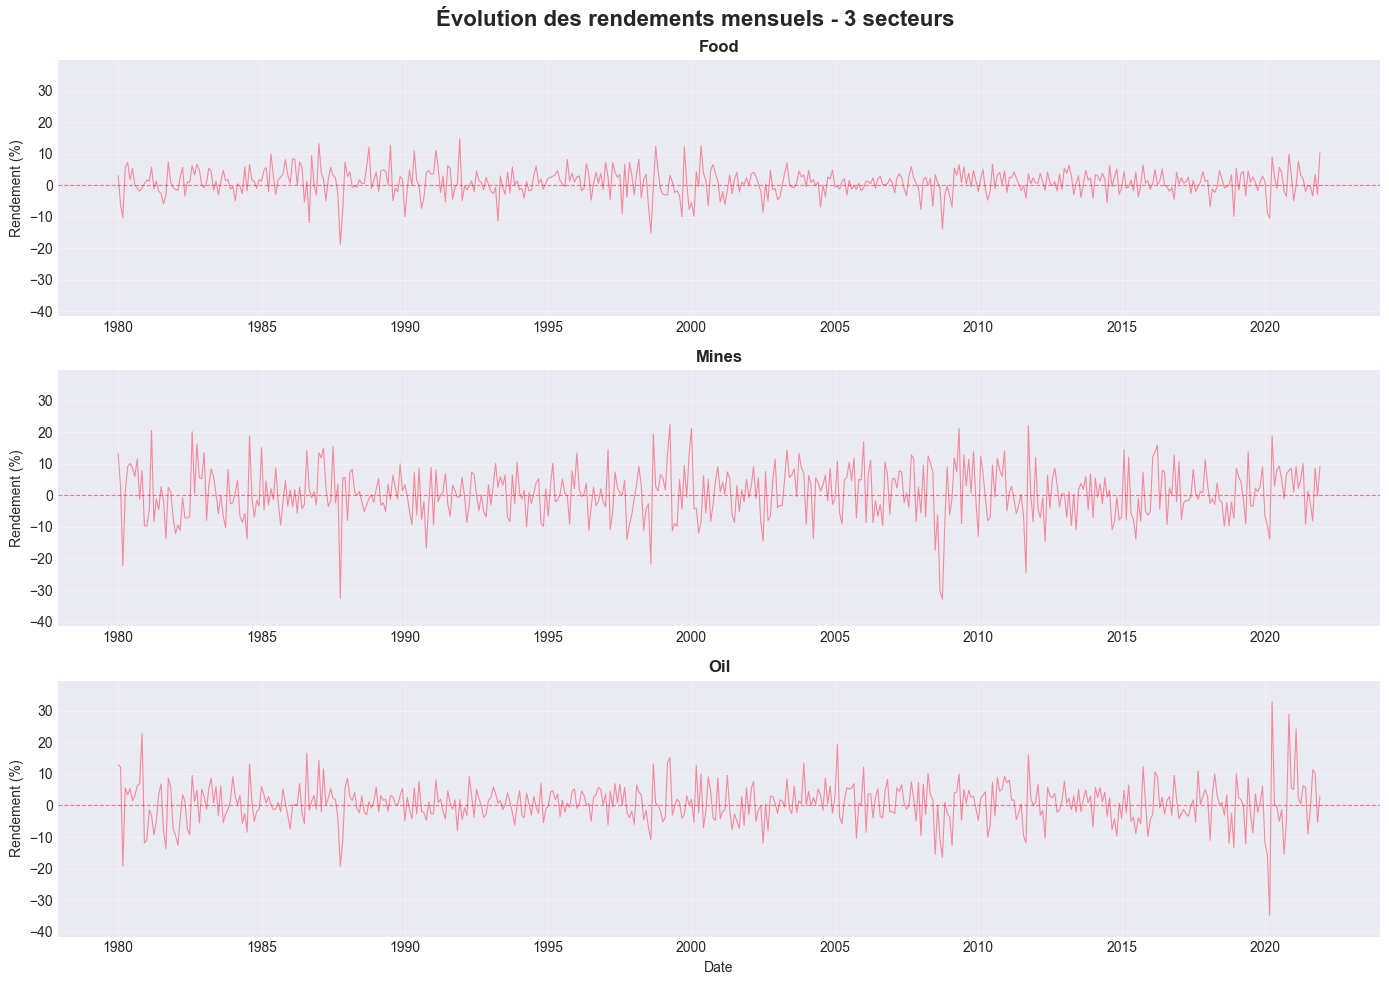

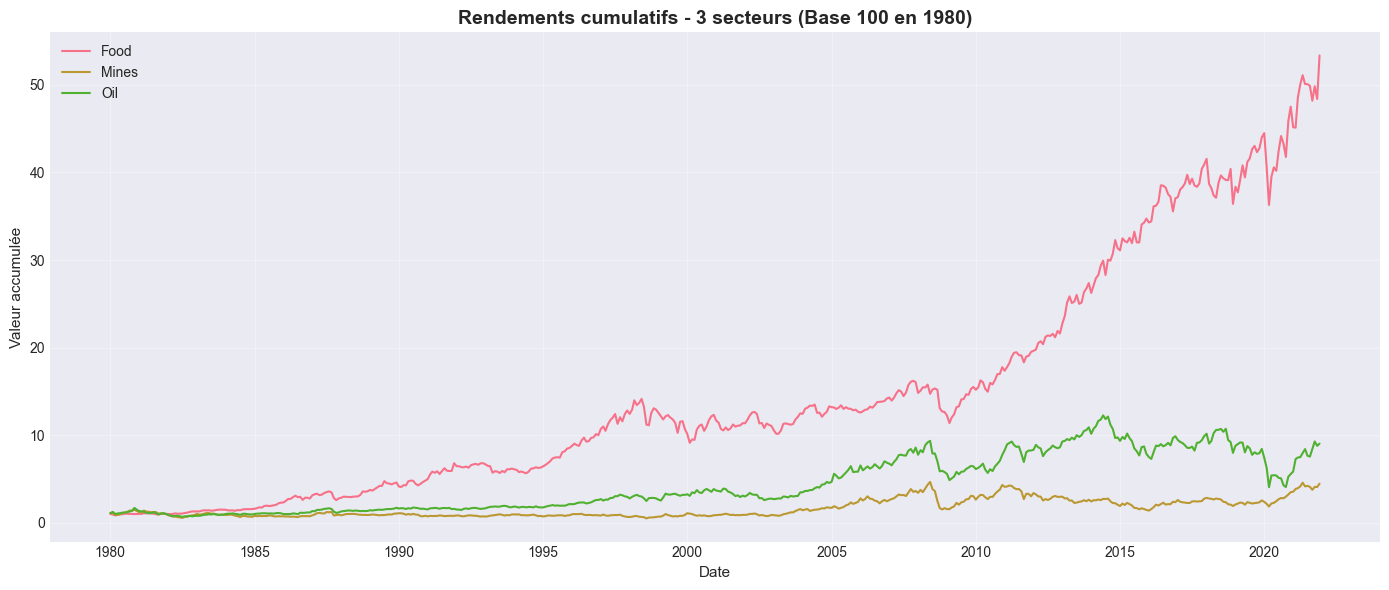

In [8]:
# Sélection de 3 secteurs intéressants (diversifiés)
selected_sectors = industries_aligned.columns[:3]  # On prendra les 3 premiers
print(f"Secteurs sélectionnés: {list(selected_sectors)}")

# Sélection de 2 facteurs (Mkt-RF et Momentum par exemple)
selected_factors = ['Mkt-RF', 'UMD']
print(f"Facteurs sélectionnés: {selected_factors}")

# Convertir l'index en datetime pour matplotlib
dates = industries_aligned.index.to_timestamp()

# Graphique 1: Séries chronologiques des 3 secteurs (avec échelle commune)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Évolution des rendements mensuels - 3 secteurs', fontsize=16, fontweight='bold')

# Déterminer l'échelle commune pour tous les secteurs
all_sector_values = [industries_aligned[sector].values for sector in selected_sectors]
y_min = min([v.min() for v in all_sector_values])
y_max = max([v.max() for v in all_sector_values])
y_range = y_max - y_min
y_min_plot = y_min - 0.1 * y_range
y_max_plot = y_max + 0.1 * y_range

for i, sector in enumerate(selected_sectors):
    axes[i].plot(dates, industries_aligned[sector], linewidth=0.8, alpha=0.8)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i].set_title(f'{sector}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Rendement (%)', fontsize=10)
    axes[i].set_ylim(y_min_plot, y_max_plot)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Calculer et afficher les rendements cumulatifs
cumulative_sectors = (1 + industries_aligned[selected_sectors]/100).cumprod()
fig, ax = plt.subplots(figsize=(14, 6))
for sector in selected_sectors:
    ax.plot(dates, cumulative_sectors[sector], label=sector, linewidth=1.5)
ax.set_title('Rendements cumulatifs - 3 secteurs (Base 100 en 1980)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Valeur accumulée', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

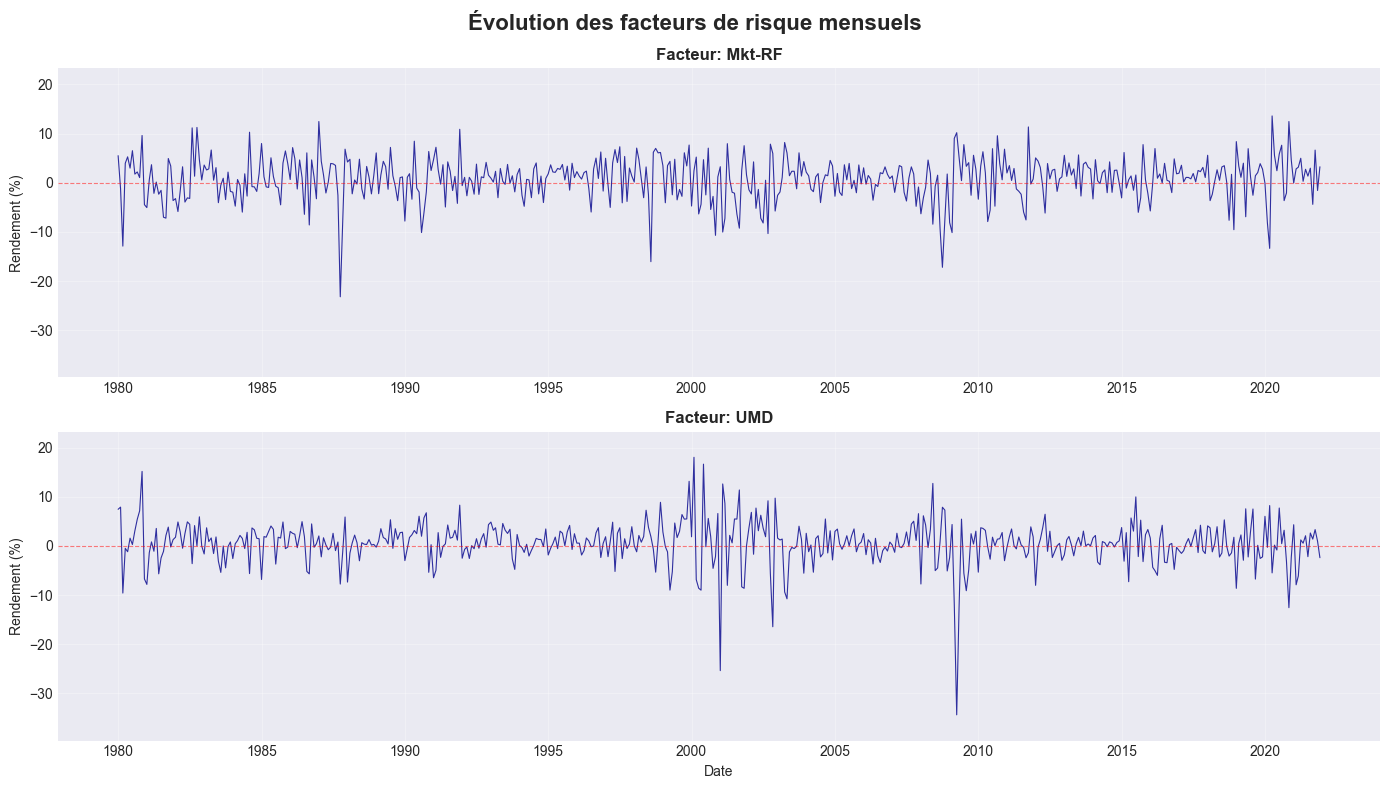

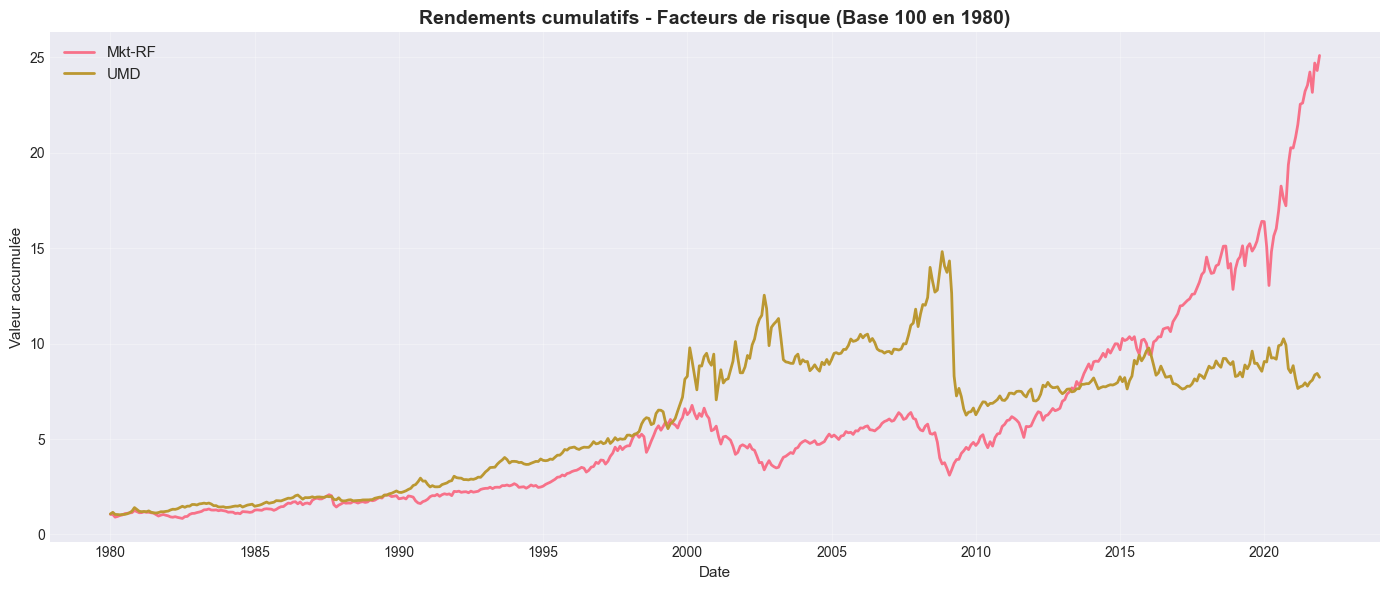

In [9]:
# Convertir l'index en datetime pour les facteurs aussi
dates_factors = factors_6_aligned.index.to_timestamp()

# Graphique 2: Séries chronologiques des 2 facteurs (avec échelle commune)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Évolution des facteurs de risque mensuels', fontsize=16, fontweight='bold')

# Déterminer l'échelle commune pour tous les facteurs
all_factor_values = [factors_6_aligned[factor].values for factor in selected_factors]
f_min = min([v.min() for v in all_factor_values])
f_max = max([v.max() for v in all_factor_values])
f_range = f_max - f_min
f_min_plot = f_min - 0.1 * f_range
f_max_plot = f_max + 0.1 * f_range

for i, factor in enumerate(selected_factors):
    axes[i].plot(dates_factors, factors_6_aligned[factor], linewidth=0.8, alpha=0.8, color='darkblue')
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i].set_title(f'Facteur: {factor}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Rendement (%)', fontsize=10)
    axes[i].set_ylim(f_min_plot, f_max_plot)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Rendements cumulatifs des facteurs
cumulative_factors = (1 + factors_6_aligned[selected_factors]/100).cumprod()
fig, ax = plt.subplots(figsize=(14, 6))
for factor in selected_factors:
    ax.plot(dates_factors, cumulative_factors[factor], label=factor, linewidth=2)
ax.set_title('Rendements cumulatifs - Facteurs de risque (Base 100 en 1980)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Valeur accumulée', fontsize=11)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Discussion des différences notables

Analysons les caractéristiques principales des séries.

In [10]:
print("=" * 80)
print("ANALYSE COMPARATIVE")
print("=" * 80)

# Comparaison des moyennes
print("\n1. RENDEMENTS MOYENS MENSUELS (%):")
print("\nFacteurs:")
print(factors_6_aligned.mean().sort_values(ascending=False).round(3))
print("\nIndustries (top 5 et bottom 5):")
ind_means = industries_aligned.mean().sort_values(ascending=False)
print(ind_means.head(5))
print("...")
print(ind_means.tail(5))

# Comparaison des volatilités
print("\n\n2. VOLATILITÉS (Écart-type en %):")
print("\nFacteurs:")
print(factors_6_aligned.std().sort_values(ascending=False).round(3))
print("\nIndustries (top 5 et bottom 5):")
ind_stds = industries_aligned.std().sort_values(ascending=False)
print(ind_stds.head(5))
print("...")
print(ind_stds.tail(5))

# Ratio de Sharpe annualisé (approximatif, en supposant RF ≈ 0)
print("\n\n3. RATIOS DE SHARPE ANNUALISÉS (approximatifs):")
sharpe_factors = (factors_6_aligned.mean() * 12) / (factors_6_aligned.std() * np.sqrt(12))
print("\nFacteurs:")
print(sharpe_factors.sort_values(ascending=False).round(3))

sharpe_industries = (industries_aligned.mean() * 12) / (industries_aligned.std() * np.sqrt(12))
print("\nIndustries (top 5):")
print(sharpe_industries.sort_values(ascending=False).head(5).round(3))

# Corrélations entre facteurs
print("\n\n4. MATRICE DE CORRÉLATION DES FACTEURS:")
corr_factors = factors_6_aligned.corr()
print(corr_factors.round(3))

ANALYSE COMPARATIVE

1. RENDEMENTS MOYENS MENSUELS (%):

Facteurs:
Mkt-RF    0.743
UMD       0.524
RMW       0.374
CMA       0.252
HML       0.203
SMB       0.095
dtype: float64

Industries (top 5 et bottom 5):
Cars     0.949306
Rtail    0.945714
Cnstr    0.920714
Cnsum    0.884861
Food     0.879683
dtype: float64
...
Utils    0.645873
Oil      0.643214
Mines    0.621488
Durbl    0.606111
Steel    0.495734
dtype: float64


2. VOLATILITÉS (Écart-type en %):

Facteurs:
UMD       4.479
Mkt-RF    4.476
HML       3.029
SMB       2.896
RMW       2.404
CMA       1.972
dtype: float64

Industries (top 5 et bottom 5):
Steel    8.184354
Mines    7.966793
Cars     7.141639
Machn    6.697971
Oil      6.394378
dtype: float64
...
Rtail    5.094841
Other    4.934326
Cnsum    4.311621
Food     4.175876
Utils    3.925489
dtype: float64


3. RATIOS DE SHARPE ANNUALISÉS (approximatifs):

Facteurs:
Mkt-RF    0.575
RMW       0.539
CMA       0.442
UMD       0.406
HML       0.232
SMB       0.114
dtype: float6

---

## Partie (b): Estimation du modèle de facteurs linéaires

Estimation par MCO du modèle: $R_{it} = \alpha_i + \beta_i^T f_t + \varepsilon_{it}$

### 1. Régression MCO pour chaque industrie

In [26]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# Préparer les données
X = factors_6_aligned.copy()  # Les 6 facteurs
X = sm.add_constant(X)  # Ajouter la constante (alpha)

# Stockage des résultats
results_dict = {}
alphas = []
betas_df = pd.DataFrame()
r2_list = []
tstat_alphas = []

print("Estimation des régressions MCO pour les 17 industries...")
print("=" * 80)

# Régression pour chaque industrie
for industry in industries_aligned.columns:
    y = industries_aligned[industry]
    
    # Estimation MCO
    model = OLS(y, X)
    result = model.fit(cov_type='HC3')  # Erreurs robustes (Heteroskedasticity-consistent)
    
    # Stocker les résultats
    results_dict[industry] = result
    alphas.append(result.params['const'])
    betas_df[industry] = result.params[1:]  # Sans la constante
    r2_list.append(result.rsquared)
    tstat_alphas.append(result.tvalues['const'])

# Transposer pour avoir les industries en lignes
betas_df = betas_df.T

print(f"✓ {len(industries_aligned.columns)} régressions estimées avec succès")
print(f"  R² moyen: {np.mean(r2_list):.4f}")
print(f"  R² min: {np.min(r2_list):.4f}")
print(f"  R² max: {np.max(r2_list):.4f}")

Estimation des régressions MCO pour les 17 industries...
✓ 17 régressions estimées avec succès
  R² moyen: 0.6776
  R² min: 0.3625
  R² max: 0.9420


### 2. R² et Alphas

In [12]:
# Extraire les écarts-types des alphas (erreurs standard)
alpha_se = []
for industry in industries_aligned.columns:
    result = results_dict[industry]
    se = result.bse['const']
    alpha_se.append(se)

# Créer un DataFrame résumé avec intervalles de confiance (95%)
summary_df = pd.DataFrame({
    'Industry': industries_aligned.columns,
    'Alpha': alphas,
    'SE(Alpha)': alpha_se,
    't-stat(Alpha)': tstat_alphas,
    'R²': r2_list
})

# Calculer les intervalles de confiance à 95%
summary_df['Alpha_Lower'] = summary_df['Alpha'] - 1.96 * summary_df['SE(Alpha)']
summary_df['Alpha_Upper'] = summary_df['Alpha'] + 1.96 * summary_df['SE(Alpha)']

print("=" * 80)
print("RÉSULTATS: R² et Alphas (avec intervalles de confiance 95%)")
print("=" * 80)

# Afficher avec IC (format: valeur, min IC, max IC)
print(f"\n{'Industry':10s} | {'Alpha':>10s} | {'IC 95% Min':>10s} | {'IC 95% Max':>10s} | {'t-stat':>7s} | {'R²':>7s}")
print("-" * 80)
for idx, row in summary_df.iterrows():
    print(f"{row['Industry']:10s} | {row['Alpha']:10.4f} | {row['Alpha_Lower']:10.4f} | {row['Alpha_Upper']:10.4f} | {row['t-stat(Alpha)']:7.3f} | {row['R²']:7.4f}")

print("\n" + "=" * 80)
print(f"R² moyen: {summary_df['R²'].mean():.4f}")
print(f"Alpha moyen: {summary_df['Alpha'].mean():.4f}")
print(f"Nombre d'alphas significatifs (|t| > 1.96): {(abs(summary_df['t-stat(Alpha)']) > 1.96).sum()}/17")
print("=" * 80)

RÉSULTATS: R² et Alphas (avec intervalles de confiance 95%)

Industry   |      Alpha | IC 95% Min | IC 95% Max |  t-stat |      R²
--------------------------------------------------------------------------------
Food       |    -0.0069 |    -0.2568 |     0.2431 |  -0.054 |  0.5991
Mines      |    -0.3346 |    -0.9691 |     0.2998 |  -1.034 |  0.3625
Oil        |    -0.3672 |    -0.8316 |     0.0972 |  -1.550 |  0.4641
Clths      |    -0.1083 |    -0.4214 |     0.2048 |  -0.678 |  0.7016
Durbl      |    -0.3557 |    -0.6291 |    -0.0822 |  -2.549 |  0.7685
Chems      |    -0.2847 |    -0.5951 |     0.0256 |  -1.798 |  0.7390
Cnsum      |     0.0957 |    -0.1717 |     0.3631 |   0.702 |  0.6179
Cnstr      |    -0.1921 |    -0.4732 |     0.0890 |  -1.339 |  0.7647
Steel      |    -0.4432 |    -0.8894 |     0.0030 |  -1.947 |  0.6592
FabPr      |    -0.2097 |    -0.4738 |     0.0544 |  -1.556 |  0.7684
Machn      |     0.3158 |     0.0603 |     0.5713 |   2.423 |  0.8214
Cars       |    -0

### 3. Bêtas estimés

In [13]:
print("=" * 80)
print("BÊTAS ESTIMÉS (Expositions aux facteurs)")
print("=" * 80)

# Extraire les écarts-types pour chaque bêta
betas_se_df = pd.DataFrame()
for industry in industries_aligned.columns:
    result = results_dict[industry]
    betas_se_df[industry] = result.bse[1:]  # Sans la constante

betas_se_df = betas_se_df.T

# Afficher les bêtas en tableau formaté
print("\nBêtas estimés (Tableau des expositions aux facteurs):")
print(betas_df.round(4).to_string())

print("\n" + "=" * 80)
print("Statistiques des bêtas:")
print(betas_df.describe().round(4))

BÊTAS ESTIMÉS (Expositions aux facteurs)

Bêtas estimés (Tableau des expositions aux facteurs):
       Mkt-RF     SMB     HML     RMW     CMA     UMD
Food   0.7881 -0.1019 -0.1012  0.5481  0.4623  0.0179
Mines  1.0424  0.4264 -0.0134  0.0314  0.5291 -0.0031
Oil    1.0154  0.1228  0.4075  0.2421  0.2337  0.0222
Clths  1.0516  0.4829  0.0970  0.7020 -0.0460 -0.2178
Durbl  1.0827  0.3858  0.0338  0.3600  0.2998 -0.1848
Chems  1.1434  0.1246  0.1967  0.3607  0.1956 -0.1269
Cnsum  0.8121 -0.2954 -0.3155  0.3774  0.5497 -0.0038
Cnstr  1.2024  0.2664  0.1463  0.3571  0.0869  0.0160
Steel  1.3339  0.4868  0.2123 -0.2160  0.1525 -0.1900
FabPr  1.0294  0.4177  0.0193  0.5354  0.0979 -0.1495
Machn  1.1311  0.1255 -0.3589 -0.3704 -0.1158 -0.1660
Cars   1.2331  0.2031  0.1021  0.2712  0.3813 -0.2271
Trans  1.0925  0.2499  0.2045  0.5373  0.0580 -0.0960
Utils  0.5914 -0.2119  0.2246  0.1320  0.2965  0.0918
Rtail  0.9486  0.1069 -0.1583  0.4817  0.0809 -0.0551
Finan  1.1114 -0.0620  0.7301  0.0384 -0

### 4. Statistiques t robustes pour les bêtas

In [14]:
# Extraire les t-stats pour chaque bêta
tstat_betas_df = pd.DataFrame()

for industry in industries_aligned.columns:
    result = results_dict[industry]
    tstat_betas_df[industry] = result.tvalues[1:]  # Sans la constante

tstat_betas_df = tstat_betas_df.T

print("=" * 80)
print("STATISTIQUES T ROBUSTES POUR LES BÊTAS")
print("=" * 80)
print(tstat_betas_df.round(3))

# Compter les coefficients significatifs
significant_betas = (abs(tstat_betas_df) > 1.96).sum()
print("\n" + "=" * 80)
print("Nombre de bêtas significatifs (|t| > 1.96) par facteur:")
print(significant_betas)
print("=" * 80)

STATISTIQUES T ROBUSTES POUR LES BÊTAS
       Mkt-RF    SMB     HML    RMW    CMA    UMD
Food   21.004 -1.748  -1.726  7.723  4.903  0.437
Mines  12.881  3.476  -0.094  0.177  2.236 -0.039
Oil    14.995  1.247   2.510  1.946  1.128  0.315
Clths  21.643  6.341   1.105  7.817 -0.363 -5.140
Durbl  29.029  7.082   0.483  4.803  3.074 -3.643
Chems  28.882  2.386   2.556  5.171  1.743 -2.688
Cnsum  22.930 -4.832  -4.669  4.514  5.089 -0.075
Cnstr  33.798  4.981   2.176  4.602  0.779  0.381
Steel  23.103  5.554   1.911 -1.777  0.885 -3.143
FabPr  27.780  6.622   0.308  5.681  1.022 -3.628
Machn  34.492  1.908  -5.014 -3.934 -1.021 -4.264
Cars   20.192  2.297   0.905  1.983  2.204 -3.269
Trans  28.877  4.748   3.520  7.418  0.636 -2.736
Utils  14.575 -3.532   2.601  1.748  2.363  2.348
Rtail  22.479  1.779  -1.918  6.247  0.726 -1.303
Finan  40.749 -1.329  12.938  0.740 -4.424 -1.967
Other  67.259  0.617  -6.597 -4.352 -2.147 -0.926

Nombre de bêtas significatifs (|t| > 1.96) par facteur:
Mkt-

### 5. Visualisation des bêtas

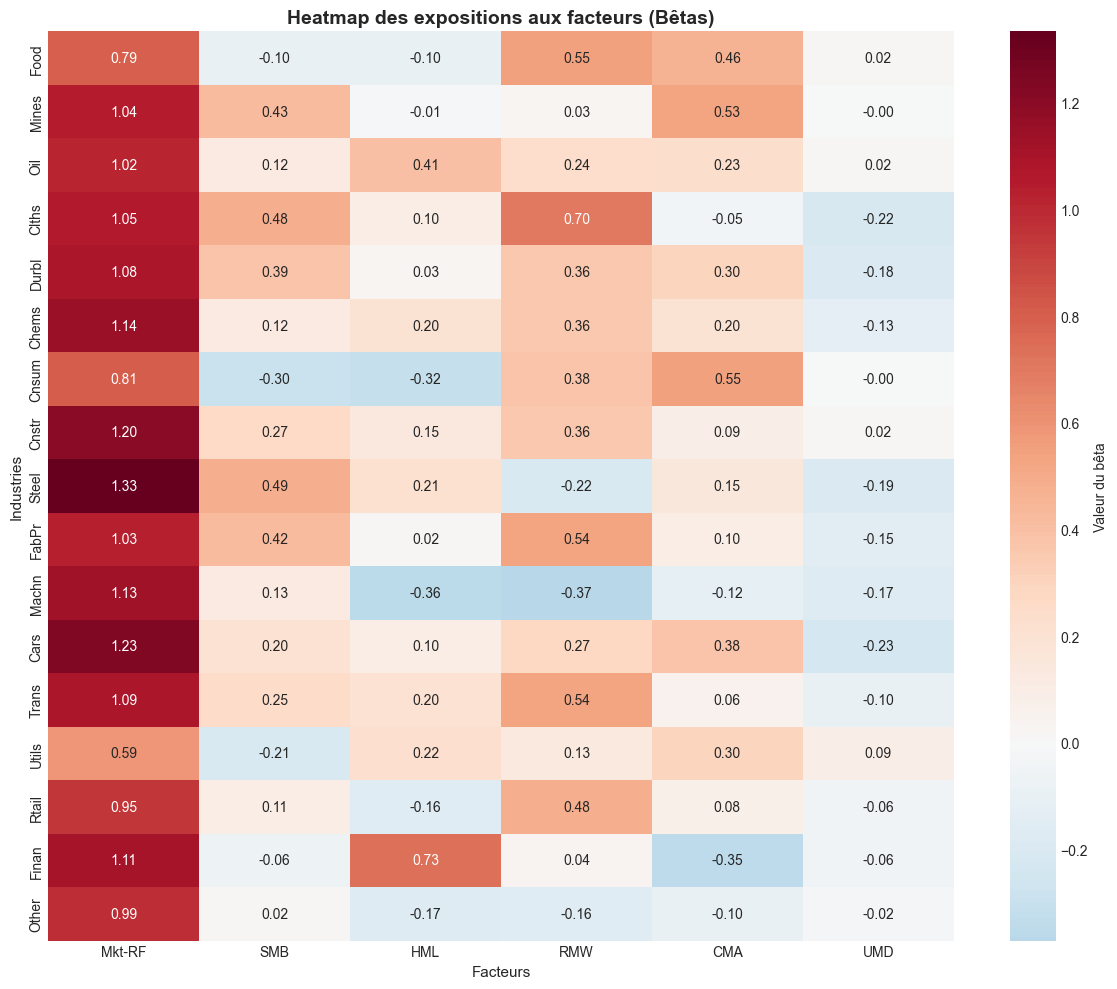

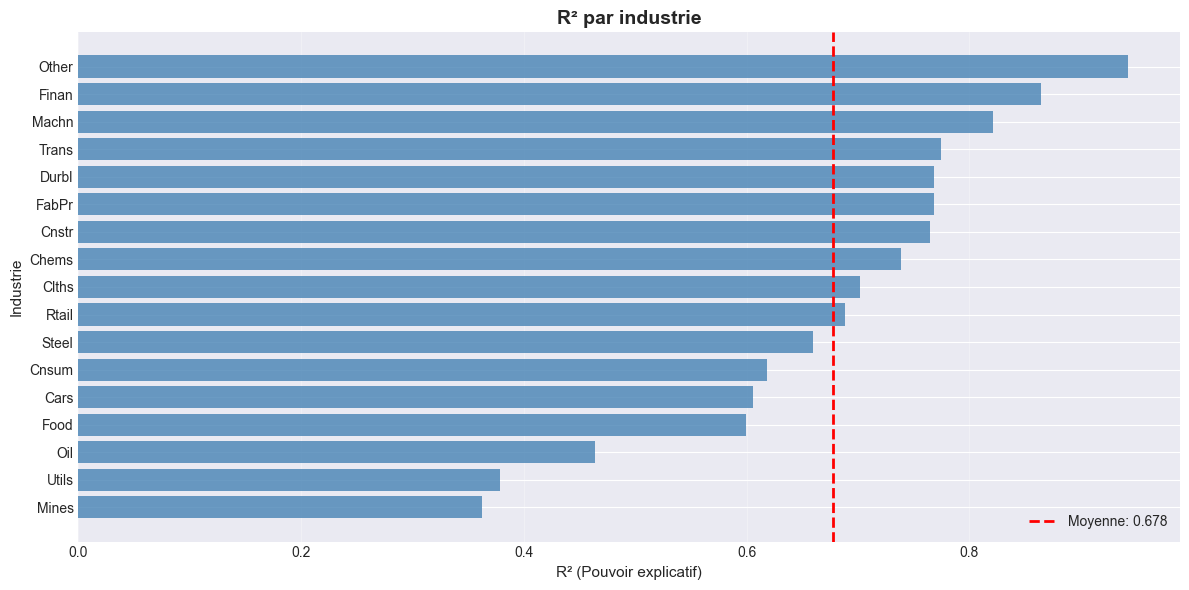

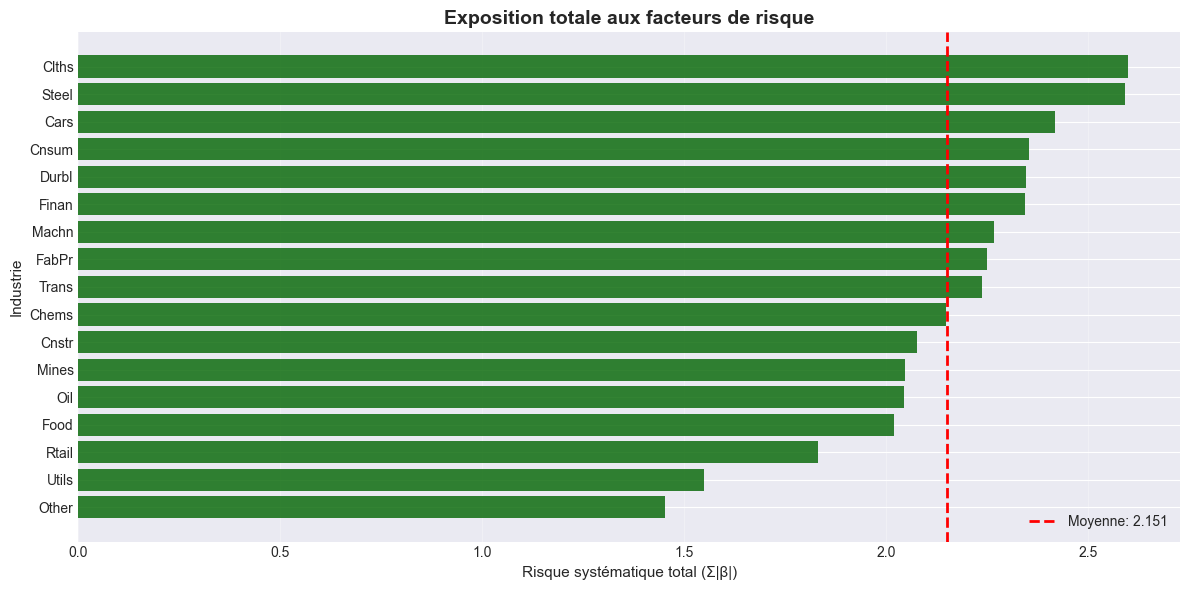

In [27]:
# Heatmap des bêtas
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(betas_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Valeur du bêta'}, ax=ax)
ax.set_title('Heatmap des expositions aux facteurs (Bêtas)', fontsize=14, fontweight='bold')
ax.set_xlabel('Facteurs', fontsize=11)
ax.set_ylabel('Industries', fontsize=11)
plt.tight_layout()
plt.show()

# Graphique des R²
fig, ax = plt.subplots(figsize=(12, 6))
summary_df_sorted = summary_df.sort_values('R²', ascending=True)
ax.barh(summary_df_sorted['Industry'], summary_df_sorted['R²'], color='steelblue', alpha=0.8)
ax.set_xlabel('R² (Pouvoir explicatif)', fontsize=11)
ax.set_ylabel('Industrie', fontsize=11)
ax.set_title('R² par industrie', fontsize=14, fontweight='bold')
ax.axvline(x=summary_df['R²'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {summary_df["R²"].mean():.3f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Risque systématique total: somme des |bêtas|
total_risk = betas_df.abs().sum(axis=1).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(total_risk.index, total_risk.values, color='darkgreen', alpha=0.8)
ax.set_xlabel('Risque systématique total (Σ|β|)', fontsize=11)
ax.set_ylabel('Industrie', fontsize=11)
ax.set_title('Exposition totale aux facteurs de risque', fontsize=14, fontweight='bold')
ax.axvline(x=total_risk.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {total_risk.mean():.3f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---

## Partie (c): Régression transversale - Facteurs négociés

Estimation des prix du risque λ et test J.

### 1. Régression transversale: $\bar{R}_i = \lambda^T \beta_i + \eta_i$

In [28]:
# Régression transversale: rendements moyens sur les bêtas estimés
y_cross = industries_aligned.mean().values  # Rendements moyens
X_cross = betas_df.values  # Bêtas estimés (sans constante pour l'instant)

# Estimation MCO des prix du risque (avec constante)
X_cross_const = sm.add_constant(X_cross)
model_cross = OLS(y_cross, X_cross_const)
result_cross = model_cross.fit(cov_type='HC3')

# Extraire les résultats
lambda_const = result_cross.params[0]  # Constante (intercept)
lambdas = result_cross.params[1:]  # Prix du risque
lambda_tstats = result_cross.tvalues[1:]
pricing_errors = result_cross.resid

print("=" * 80)
print("RÉGRESSION TRANSVERSALE - Facteurs négociés")
print("=" * 80)
print(f"\nConstante (intercept): {lambda_const:.4f} (t = {result_cross.tvalues[0]:.3f})")
print("\nPrix du risque (λ) estimés avec IC 95%:")

# Calculer les IC 95% pour les lambdas
lambda_se = result_cross.bse[1:]
lambda_lower = lambdas - 1.96 * lambda_se
lambda_upper = lambdas + 1.96 * lambda_se

lambda_df = pd.DataFrame({
    'Facteur': factors_6_aligned.columns,
    'Lambda': lambdas,
    'IC 95% Min': lambda_lower,
    'IC 95% Max': lambda_upper,
    't-stat': lambda_tstats
})
print(lambda_df.round(4).to_string(index=False))
print("\n" + "=" * 80)

RÉGRESSION TRANSVERSALE - Facteurs négociés

Constante (intercept): 0.2707 (t = 0.820)

Prix du risque (λ) estimés avec IC 95%:
Facteur  Lambda  IC 95% Min  IC 95% Max  t-stat
 Mkt-RF  0.5406     -0.1029      1.1842  1.6465
    SMB -0.4329     -0.9450      0.0792 -1.6570
    HML -0.2964     -0.5317     -0.0611 -2.4685
    RMW  0.3419      0.1267      0.5571  3.1140
    CMA -0.2152     -0.6016      0.1712 -1.0914
    UMD  0.1792     -1.1183      1.4766  0.2707



### 2. Test J (Hansen-Jagannathan)

In [17]:
from scipy import stats

# Test J: H0: toutes les erreurs d'évaluation sont nulles
N = len(pricing_errors)  # Nombre d'actifs
K = len(lambdas)  # Nombre de facteurs

# Statistique J (chi-carré)
# J = N * R² de la régression auxiliaire des erreurs sur une constante
# Équivalent: tester si les erreurs sont conjointement nulles
ssr_errors = np.sum(pricing_errors**2)
tsr = np.sum((y_cross - np.mean(y_cross))**2)
r2_cross = 1 - ssr_errors/tsr

# Degrés de liberté: N - K - 1 (nombre d'actifs - nombre de facteurs - constante)
df_j = N - K - 1

# Statistique J alternative: test de restriction
# On teste si les erreurs sont conjointement nulles
J_stat = N * r2_cross
p_value_j = 1 - stats.chi2.cdf(J_stat, df_j)

print("=" * 80)
print("TEST J - Performance du modèle (Facteurs négociés)")
print("=" * 80)
print(f"\nStatistique J: {J_stat:.4f}")
print(f"Degrés de liberté: {df_j}")
print(f"p-value: {p_value_j:.4f}")
print(f"\nR² de la régression transversale: {r2_cross:.4f}")
print(f"RMSE des erreurs d'évaluation: {np.sqrt(np.mean(pricing_errors**2)):.4f}%")

if p_value_j < 0.05:
    print(f"\n✗ Rejet H0 (p < 0.05): Le modèle ne capture pas toutes les erreurs d'évaluation")
else:
    print(f"\n✓ Non-rejet H0 (p ≥ 0.05): Le modèle explique bien la coupe transversale")
    
print("=" * 80)

TEST J - Performance du modèle (Facteurs négociés)

Statistique J: 12.3417
Degrés de liberté: 10
p-value: 0.2628

R² de la régression transversale: 0.7260
RMSE des erreurs d'évaluation: 0.0679%

✓ Non-rejet H0 (p ≥ 0.05): Le modèle explique bien la coupe transversale


### 3. Erreurs d'évaluation par industrie

ERREURS D'ÉVALUATION (η_i) - Facteurs négociés
   Industry  R_mean  R_predicted  Pricing_Error
0      Food  0.8797       0.8620         0.0176
1     Mines  0.6215       0.5499         0.0715
2       Oil  0.6432       0.6822        -0.0390
3     Clths  0.8760       0.8123         0.0637
4     Durbl  0.6061       0.7045        -0.0984
5     Chems  0.7347       0.8351        -0.1004
6     Cnsum  0.8849       0.9412        -0.0564
7     Cnstr  0.9207       0.8683         0.0524
8     Steel  0.4957       0.5775        -0.0817
9     FabPr  0.7458       0.7759        -0.0301
10    Machn  0.8408       0.8028         0.0380
11     Cars  0.9493       0.7891         0.1602
12    Trans  0.7959       0.8466        -0.0507
13    Utils  0.6459       0.6134         0.0325
14    Rtail  0.9457       0.9216         0.0241
15    Finan  0.7948       0.7597         0.0351
16    Other  0.7732       0.8116        -0.0384


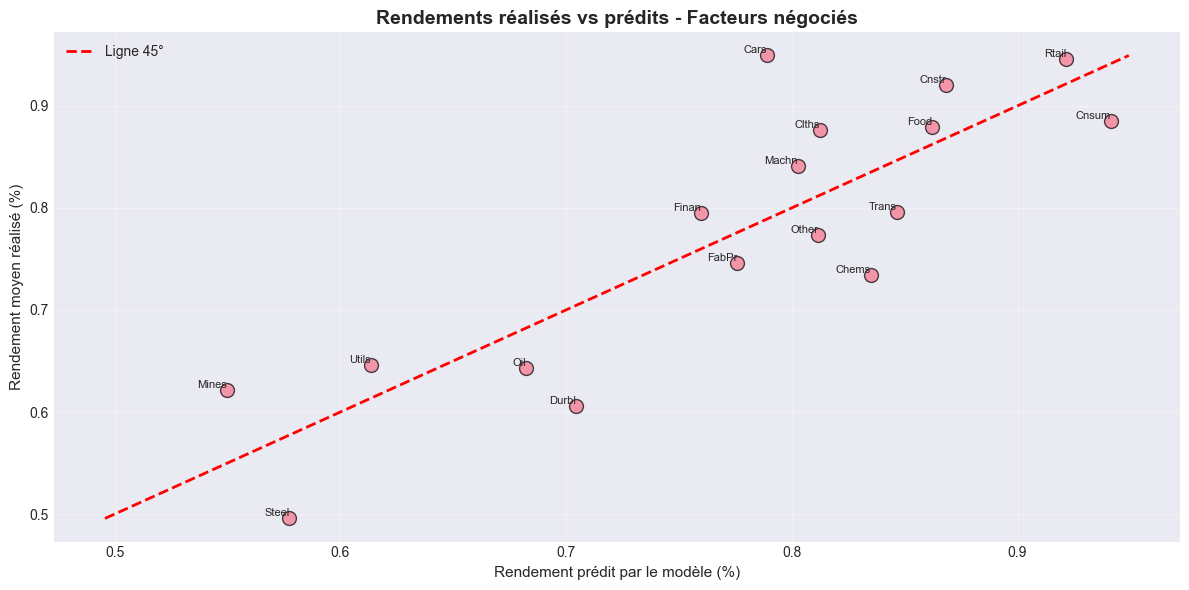

In [18]:
# Tableau des erreurs d'évaluation
errors_df_c = pd.DataFrame({
    'Industry': industries_aligned.columns,
    'R_mean': y_cross,
    'R_predicted': result_cross.fittedvalues,
    'Pricing_Error': pricing_errors
})

print("=" * 80)
print("ERREURS D'ÉVALUATION (η_i) - Facteurs négociés")
print("=" * 80)
print(errors_df_c.round(4))
print("=" * 80)

# Graphique
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(errors_df_c['R_predicted'], errors_df_c['R_mean'], s=100, alpha=0.7, edgecolors='black')
for idx, row in errors_df_c.iterrows():
    ax.annotate(row['Industry'], (row['R_predicted'], row['R_mean']), 
                fontsize=8, ha='right', va='bottom')
    
# Ligne 45 degrés
min_val = min(errors_df_c['R_predicted'].min(), errors_df_c['R_mean'].min())
max_val = max(errors_df_c['R_predicted'].max(), errors_df_c['R_mean'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ligne 45°')

ax.set_xlabel('Rendement prédit par le modèle (%)', fontsize=11)
ax.set_ylabel('Rendement moyen réalisé (%)', fontsize=11)
ax.set_title('Rendements réalisés vs prédits - Facteurs négociés', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Partie (d): Régression transversale - Facteurs non négociés

Contrainte: $\lambda = \bar{f}$ (prix du risque = rendement moyen des facteurs)

### 1. Calcul avec contrainte $\lambda = \bar{f}$

In [30]:
# Facteurs non négociés: lambda = rendement moyen des facteurs
lambdas_nontrade = factors_6_aligned.mean().values

# Calculer les rendements prédits: R_predicted = lambda^T * beta
R_predicted_nontrade = betas_df.values @ lambdas_nontrade

# Erreurs d'évaluation = Alphas de la première étape
pricing_errors_nontrade = y_cross - R_predicted_nontrade

print("=" * 80)
print("FACTEURS NON NÉGOCIÉS - Contrainte: λ = E[f]")
print("=" * 80)
print("\nPrix du risque (= rendement moyen des facteurs) avec IC 95% et t-stats robustes:")

# Calculer les IC 95% basés sur l'erreur standard de la moyenne
n_obs = len(factors_6_aligned)
lambda_nontrade_se = factors_6_aligned.std() / np.sqrt(n_obs)
lambda_nontrade_lower = lambdas_nontrade - 1.96 * lambda_nontrade_se
lambda_nontrade_upper = lambdas_nontrade + 1.96 * lambda_nontrade_se

# Calculer les t-stats robustes pour les lambdas non négociés
# t-stat = lambda / SE
lambda_nontrade_tstats = lambdas_nontrade / lambda_nontrade_se

lambda_nontrade_df = pd.DataFrame({
    'Facteur': factors_6_aligned.columns,
    'Lambda (= E[f])': lambdas_nontrade,
    'IC 95% Min': lambda_nontrade_lower,
    'IC 95% Max': lambda_nontrade_upper,
    't-stat': lambda_nontrade_tstats
})
print(lambda_nontrade_df.round(4).to_string(index=False))
print("\n" + "=" * 80)

FACTEURS NON NÉGOCIÉS - Contrainte: λ = E[f]

Prix du risque (= rendement moyen des facteurs) avec IC 95% et t-stats robustes:
Facteur  Lambda (= E[f])  IC 95% Min  IC 95% Max  t-stat
 Mkt-RF           0.7433      0.3525      1.1341  3.7282
    SMB           0.0952     -0.1577      0.3481  0.7379
    HML           0.2032     -0.0613      0.4676  1.5060
    RMW           0.3742      0.1643      0.5840  3.4949
    CMA           0.2519      0.0797      0.4241  2.8676
    UMD           0.5243      0.1333      0.9153  2.6280



### 2. Test J (Facteurs non négociés)

In [20]:
# Test J pour facteurs non négociés
ssr_errors_nontrade = np.sum(pricing_errors_nontrade**2)
r2_nontrade = 1 - ssr_errors_nontrade/tsr

# Degrés de liberté: N (pas d'estimation de lambda, contrainte imposée)
df_j_nontrade = N

# Statistique J
J_stat_nontrade = N * (1 - r2_nontrade)
p_value_j_nontrade = 1 - stats.chi2.cdf(J_stat_nontrade, df_j_nontrade)

print("=" * 80)
print("TEST J - Performance du modèle (Facteurs NON négociés)")
print("=" * 80)
print(f"\nStatistique J: {J_stat_nontrade:.4f}")
print(f"Degrés de liberté: {df_j_nontrade}")
print(f"p-value: {p_value_j_nontrade:.4f}")
print(f"\nRMSE des erreurs d'évaluation: {np.sqrt(np.mean(pricing_errors_nontrade**2)):.4f}%")

if p_value_j_nontrade < 0.05:
    print(f"\n✗ Rejet H0 (p < 0.05): Présence d'alphas significatifs")
else:
    print(f"\n✓ Non-rejet H0 (p ≥ 0.05): Pas d'alpha significatif")
    
print("=" * 80)

TEST J - Performance du modèle (Facteurs NON négociés)

Statistique J: 57.2561
Degrés de liberté: 17
p-value: 0.0000

RMSE des erreurs d'évaluation: 0.2379%

✗ Rejet H0 (p < 0.05): Présence d'alphas significatifs


---

### 3. Comparaison: Facteurs négociés vs non-négociés

In [21]:
# Tableau de comparaison
comparison_data = {
    'Spécification': ['Facteurs négociés (c)', 'Facteurs non-négociés (d)'],
    'Statistique J': [J_stat, J_stat_nontrade],
    'df': [df_j, df_j_nontrade],
    'p-value': [p_value_j, p_value_j_nontrade],
    'RMSE': [np.sqrt(np.mean(pricing_errors**2)), np.sqrt(np.mean(pricing_errors_nontrade**2))]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("COMPARAISON: Facteurs négociés vs non-négociés")
print("=" * 80 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "=" * 80)

# Déterminer la meilleure spécification
if J_stat < J_stat_nontrade:
    print("\n✓ Facteurs NÉGOCIÉS: J plus faible, meilleur ajustement")
else:
    print("\n✓ Facteurs NON-NÉGOCIÉS: J plus faible, meilleur ajustement")
print("=" * 80)


COMPARAISON: Facteurs négociés vs non-négociés

            Spécification  Statistique J  df  p-value     RMSE
    Facteurs négociés (c)      12.341671  10 0.262840 0.067864
Facteurs non-négociés (d)      57.256102  17 0.000003 0.237921


✓ Facteurs NÉGOCIÉS: J plus faible, meilleur ajustement
